# Imports and Defaults

In [1]:
import os

import numpy as np
import polars as pl
import seaborn as sns

In [2]:
sns.set_theme(style="darkgrid")
experiment = "funnel10"
data_dir = os.path.join("..", "..", "data", experiment)

# NUTS

### Trace and Histogram Plots

In [3]:
sampler_params = "sampler_type=nuts__seed=1234__burn_in=0__gradient_budget=1000000__chain=0"
path = os.path.join(data_dir, sampler_params, "history.npz")

history_np = np.load(path)
grad_evals_np, draws_np = history_np["grad_evals"], history_np["draws"]

data = np.hstack([grad_evals_np.reshape(-1, 1), draws_np])
schema = [("grad_evals", pl.UInt32)] + [(f"p{i}", pl.Float32) for i in range(draws_np.shape[1])]
history = pl.from_numpy(data=data, schema=schema)

history.head()

FileNotFoundError: [Errno 2] No such file or directory: '../../data/funnel10/sampler_type=nuts__seed=1234__burn_in=0__gradient_budget=1000000__chain=0/history.npz'

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


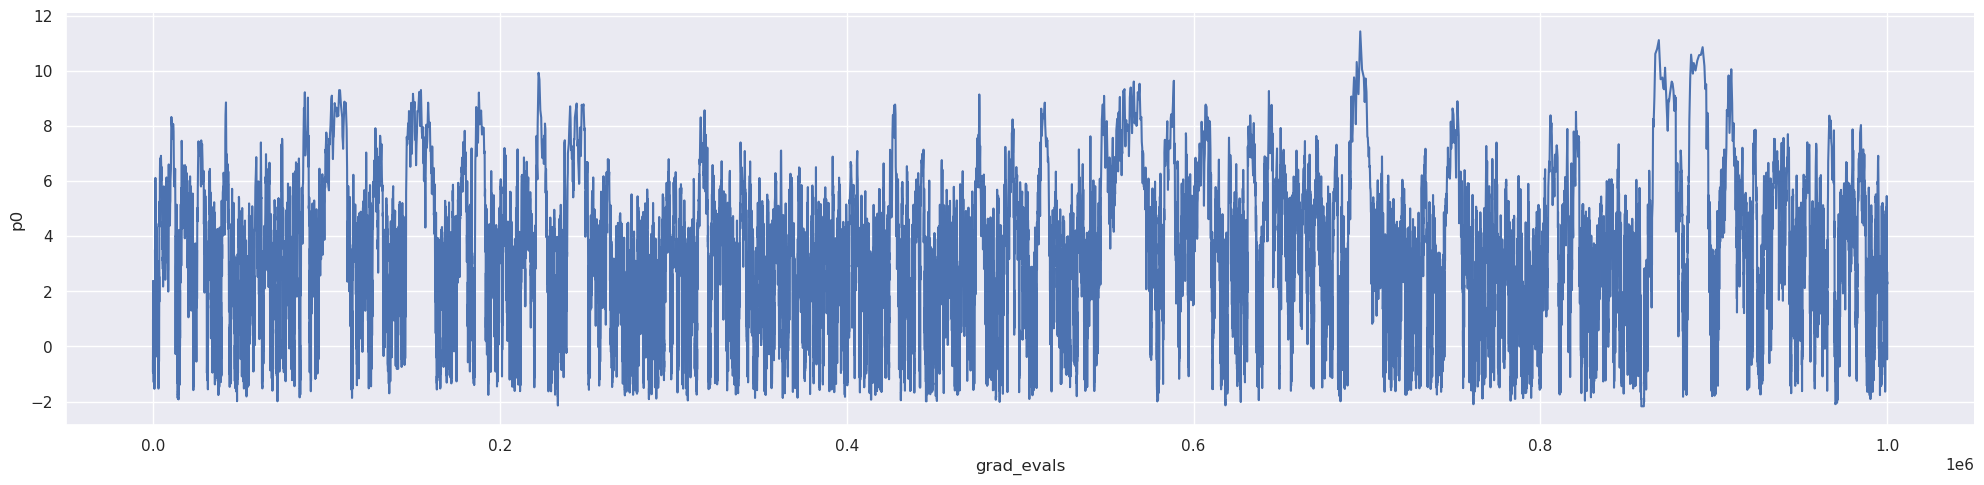

In [ ]:
fig = sns.relplot(
    data=history,
    kind="line",
    x="grad_evals",
    y="p0",
    aspect=4,
)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


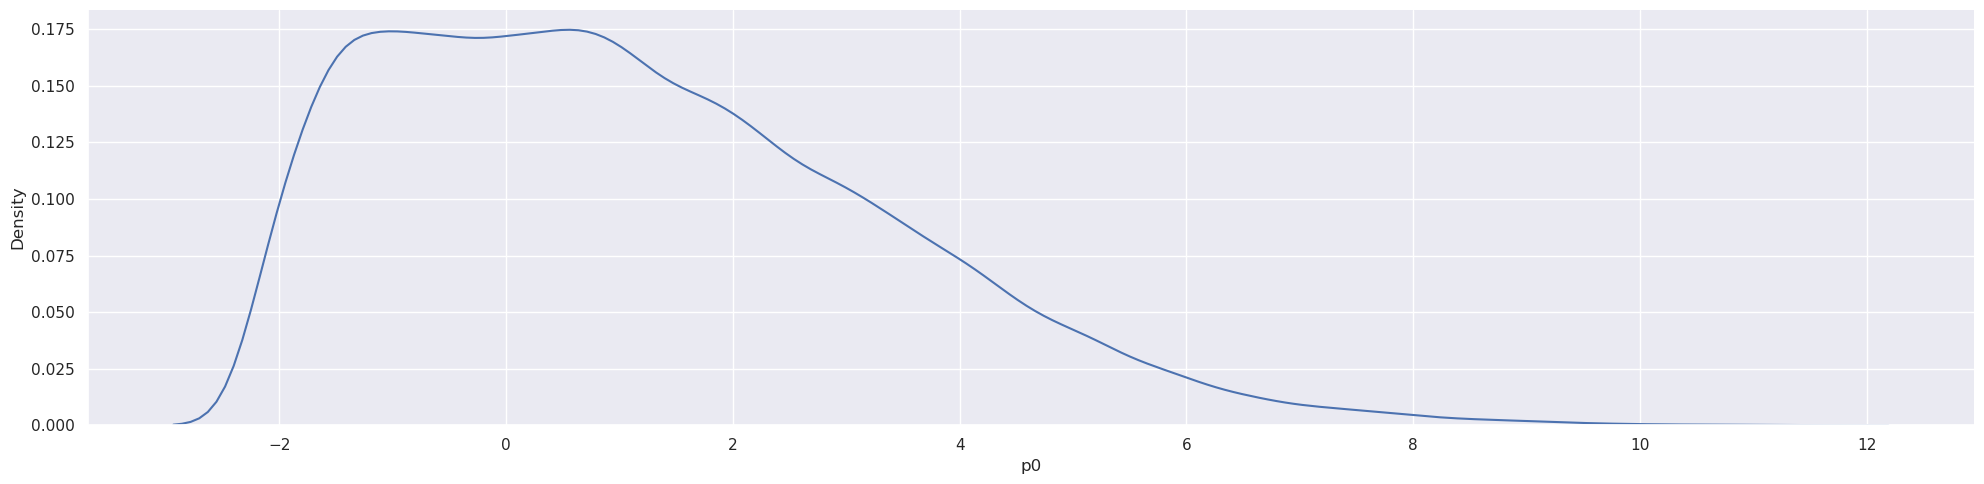

In [6]:
sns.displot(
    data=history,
    x="p0",
    kind="kde",
    aspect=4,
)

### Squared Error

In [7]:
sampler_params = "sampler_type=nuts__seed=1234__burn_in=0__gradient_budget=1000000__chain=0"
path = os.path.join(data_dir, sampler_params, "metrics.npz")

metrics_np = np.load(path)
se1_np = metrics_np["max_se1"]

data = np.hstack([grad_evals_np.reshape(-1, 1), se1_np.reshape(-1, 1)])
schema = [("grad_evals", pl.UInt32), ("se1", pl.Float32)]
se1 = pl.from_numpy(data=data, schema=schema)

se1.head()

grad_evals,se1
u32,f32
7,2.230012
14,0.515938
21,0.39283
28,0.214112
43,0.17163


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


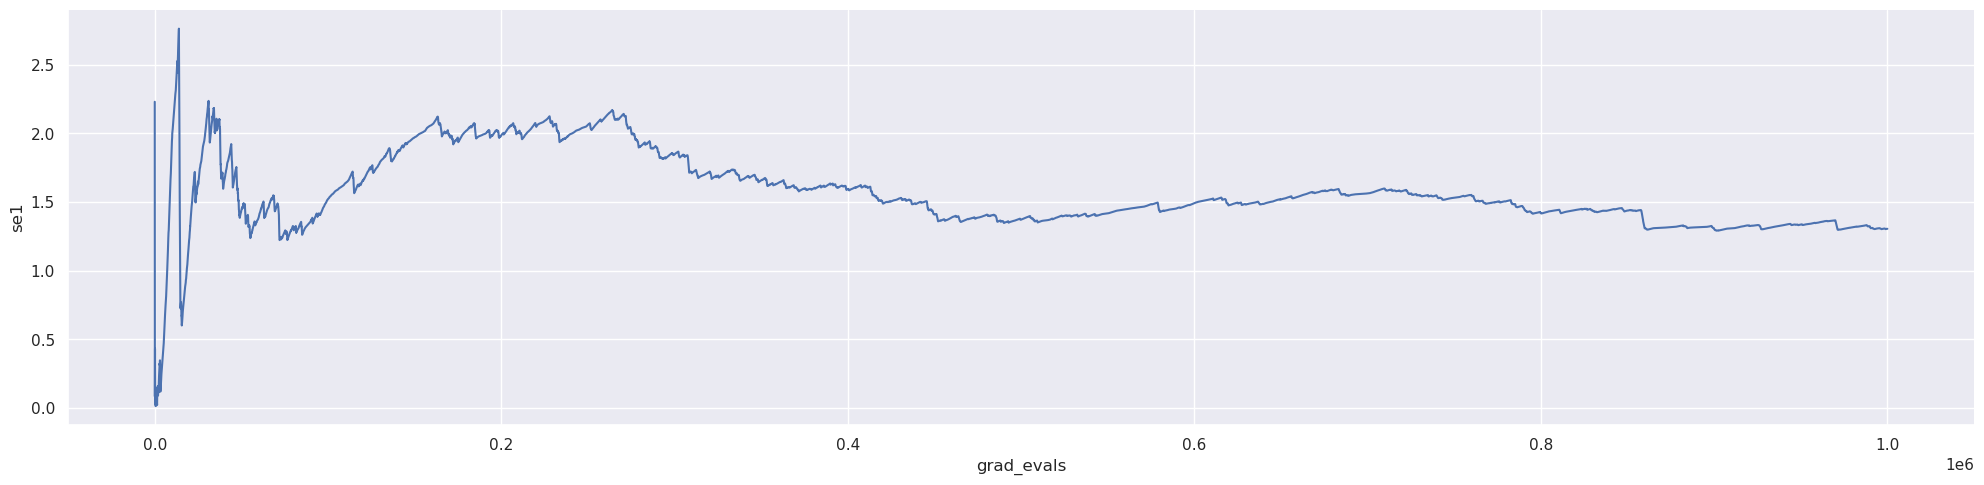

In [8]:
sns.relplot(
    data=se1,
    kind="line",
    x="grad_evals",
    y="se1",
    aspect=4,
)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


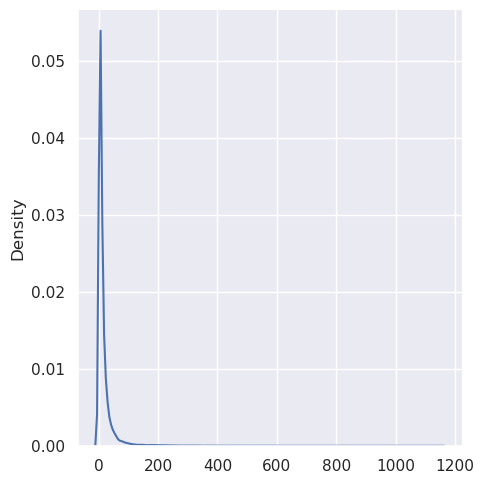

In [9]:
sns.displot(
    kind="kde",
    x=metrics_np["uturn_dist"],
)

### Squared Error Across all chains

In [13]:
def get_df(param_str="sampler_type=nuts__seed=1234__burn_in=0__gradient_budget=1000000"):
    to_vstack = []
    for idx in range(5):
        to_hstack = []
        fname = param_str + f"__chain={idx}"
        
        history_path = os.path.join(data_dir, fname, "history.npz")
        history_np = np.load(history_path)
        metrics_path = os.path.join(data_dir, fname, "metrics.npz")
        metrics_np = np.load(metrics_path)

        to_hstack.append(history_np["grad_evals"].round(-3))
        to_hstack.append(history_np["draws"][:, 0])
        to_hstack.append(metrics_np["max_se1"])
        to_hstack.append(metrics_np["max_se2"])
        to_hstack.append(np.array([idx] * len(history_np["grad_evals"])))
        to_hstack.append(np.array(["nuts"] * len(history_np["grad_evals"])))
        data = np.hstack([arr.reshape(-1, 1) for arr in to_hstack])
        to_vstack.append(data)
    
    data = np.vstack(to_vstack)
    schema = [("grad_evals", pl.UInt32), ("p0", pl.Float32), ("se1", pl.Float32),  ("se2", pl.Float32), ("chain", pl.UInt32), ("sampler", pl.Utf8)]
    return pl.from_numpy(data=data, schema=schema)
    
squared_error = get_df()
squared_error.tail()

ComputeError: strict conversion from `str` to `u32` failed for column: grad_evals, value(s) ["746000.0", "16000.0", … "725000.0"]; if you were trying to cast Utf8 to temporal dtypes, consider using `strptime`

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


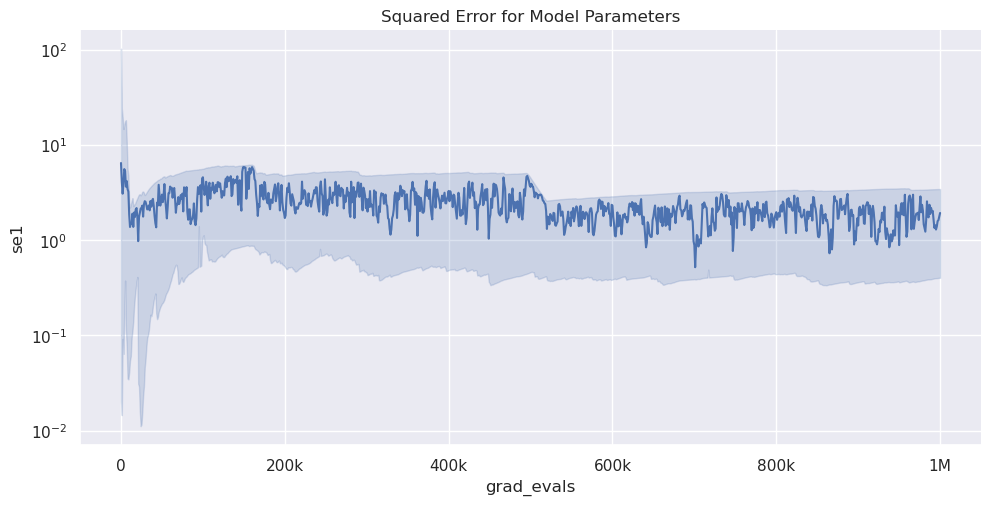

In [11]:
fig = sns.relplot(
    data=squared_error,
    kind="line",
    x="grad_evals",
    y="se1",
    aspect=2,
    errorbar=lambda x: (x.min(), x.max()),
)

fig.set(yscale="log")
fig.set(xticks=[0, 200_000, 400_000, 600_000, 800_000, 1_000_000], xticklabels=["0", "200k", "400k", "600k", "800k", "1M"])
fig.set(title="Squared Error for Model Parameters")

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


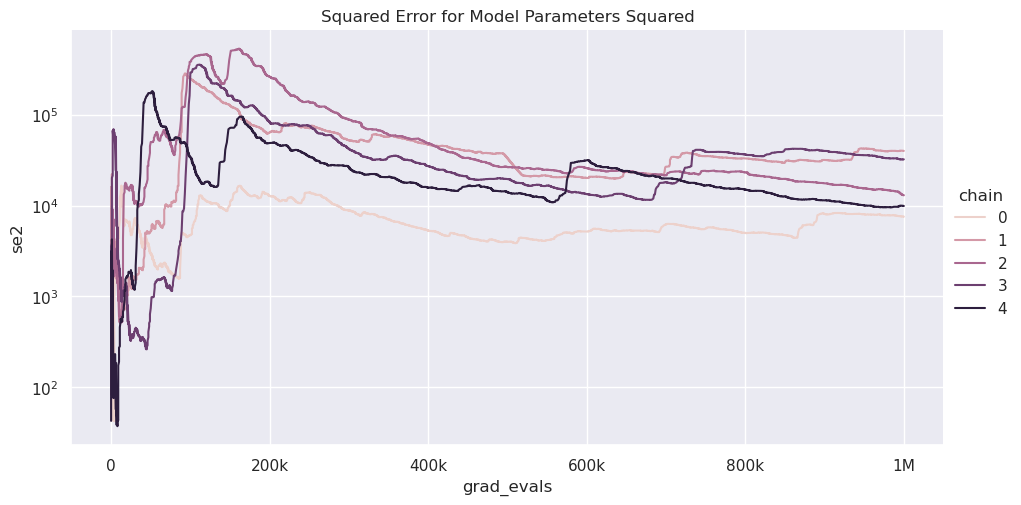

In [12]:
fig = sns.relplot(
    data=squared_error,
    kind="line",
    x="grad_evals",
    y="se2",
    aspect=2,
    units="chain",
    estimator=None,
    hue="chain",
    # errorbar=lambda x: (x.min(), x.max()),
)

# make y axis log scale
fig.set(yscale="log")
fig.set(xticks=[0, 200_000, 400_000, 600_000, 800_000, 1_000_000], xticklabels=["0", "200k", "400k", "600k", "800k", "1M"])
fig.set(title="Squared Error for Model Parameters Squared")

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


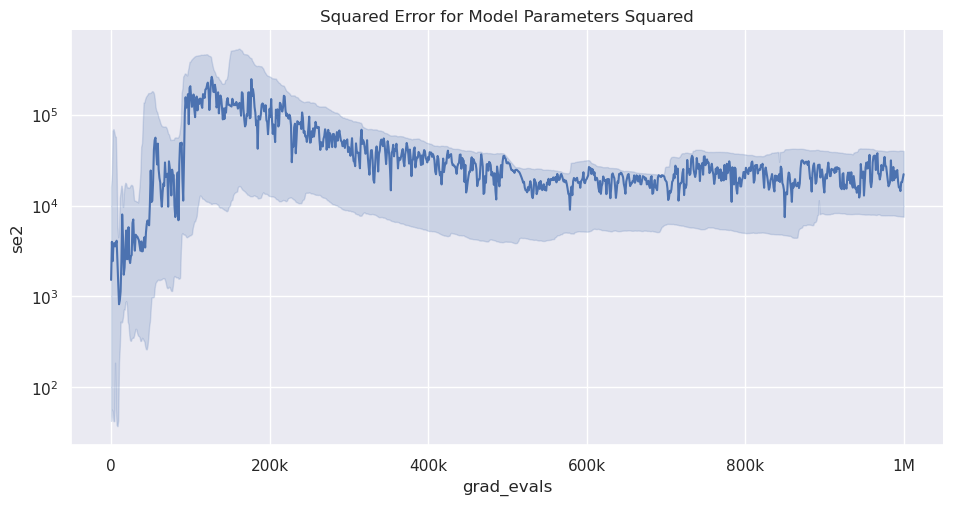

In [13]:
fig = sns.relplot(
    data=squared_error,
    kind="line",
    x="grad_evals",
    y="se2",
    aspect=2,
    errorbar=lambda x: (x.min(), x.max()),
)

# make y axis log scale
fig.set(yscale="log")
fig.set(xticks=[0, 200_000, 400_000, 600_000, 800_000, 1_000_000], xticklabels=["0", "200k", "400k", "600k", "800k", "1M"])
fig.set(title="Squared Error for Model Parameters Squared")

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


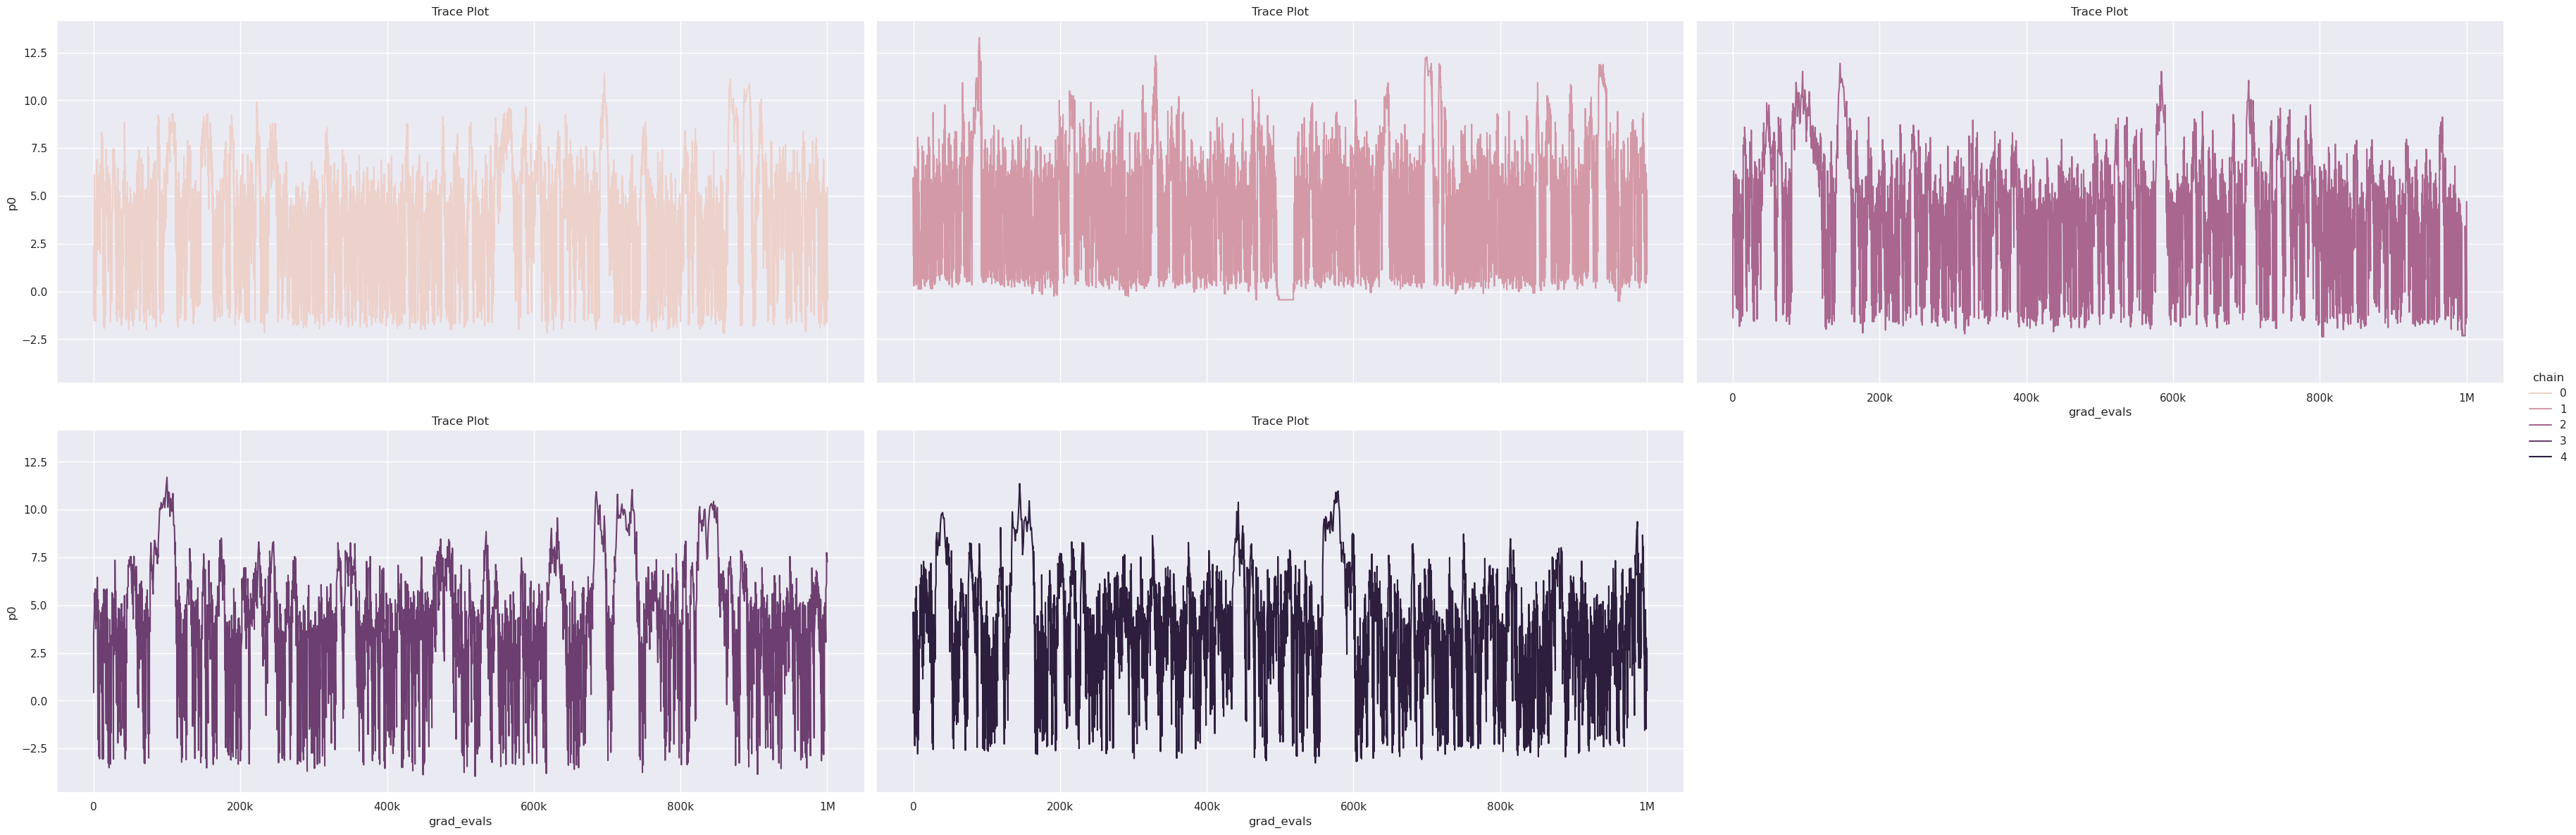

In [14]:
fig = sns.relplot(
    data=squared_error,
    kind="line",
    x="grad_evals",
    y="p0",
    estimator=None,
    col="chain",
    hue="chain",
    col_wrap=3,
    aspect=2,
    height=6,
)

fig.set(xticks=[0, 200_000, 400_000, 600_000, 800_000, 1_000_000], xticklabels=["0", "200k", "400k", "600k", "800k", "1M"])
fig.set(title="Trace Plot")

# DRGHMC

In [19]:
dir_name ="sampler_type=drghmc__seed=1234__burn_in=0__gradient_budget=1000000__chain=0__step_count_method=const_step_count__step_size=None__step_size_factor=2.0__max_proposals=3__reduction_factor=4.0__damping=0.05__metric=1__probabilistic=False"
history_path = os.path.join(data_dir, dir_name, "history.npz")
history_np = np.load(history_path)
metrics_path = os.path.join(data_dir, dir_name, "metrics.npz")
metrics_np = np.load(metrics_path)

to_hstack = []
to_hstack.append(history_np["grad_evals"].round(-3)) # .round(-4)
to_hstack.append(history_np["draws"][:, 0])
to_hstack.append(metrics_np["max_se1"])
to_hstack.append(metrics_np["max_se2"])

print([arr.shape for arr in to_hstack])
data = np.hstack([arr.reshape(-1, 1) for arr in to_hstack])
schema = [("grad_evals", pl.UInt32), ("p0", pl.Float32), ("se1", pl.Float32),  ("se2", pl.Float32)]
df = pl.from_numpy(data=data, schema=schema)

[(741704,), (741704,), (741704,), (741704,)]


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


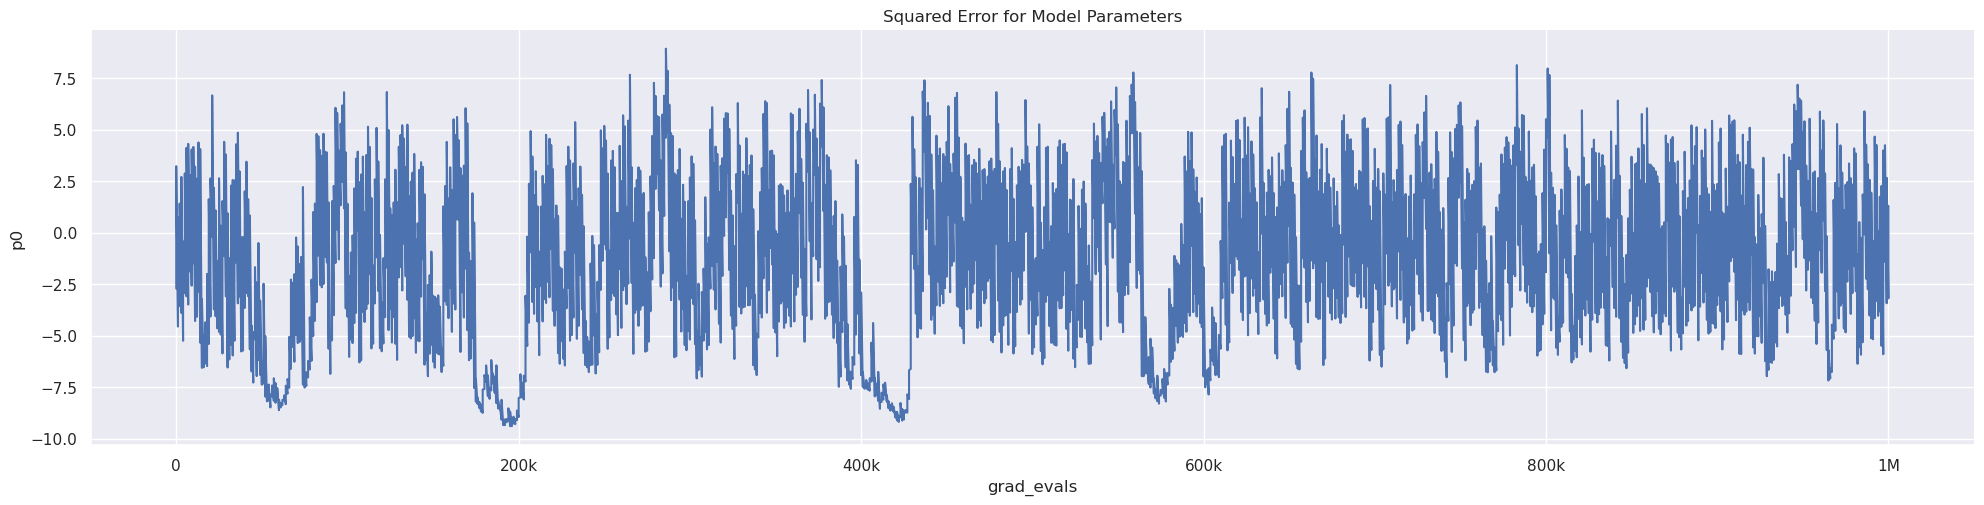

In [16]:
fig = sns.relplot(
    data=df,
    kind="line",
    x="grad_evals",
    y="p0",
    aspect=4,
    estimator=None,
    # errorbar=lambda x: (x.min(), x.max()),
)

# make y axis log scale
# fig.set(yscale="log")
fig.set(xticks=[0, 200_000, 400_000, 600_000, 800_000, 1_000_000], xticklabels=["0", "200k", "400k", "600k", "800k", "1M"])
fig.set(title="Squared Error for Model Parameters")

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


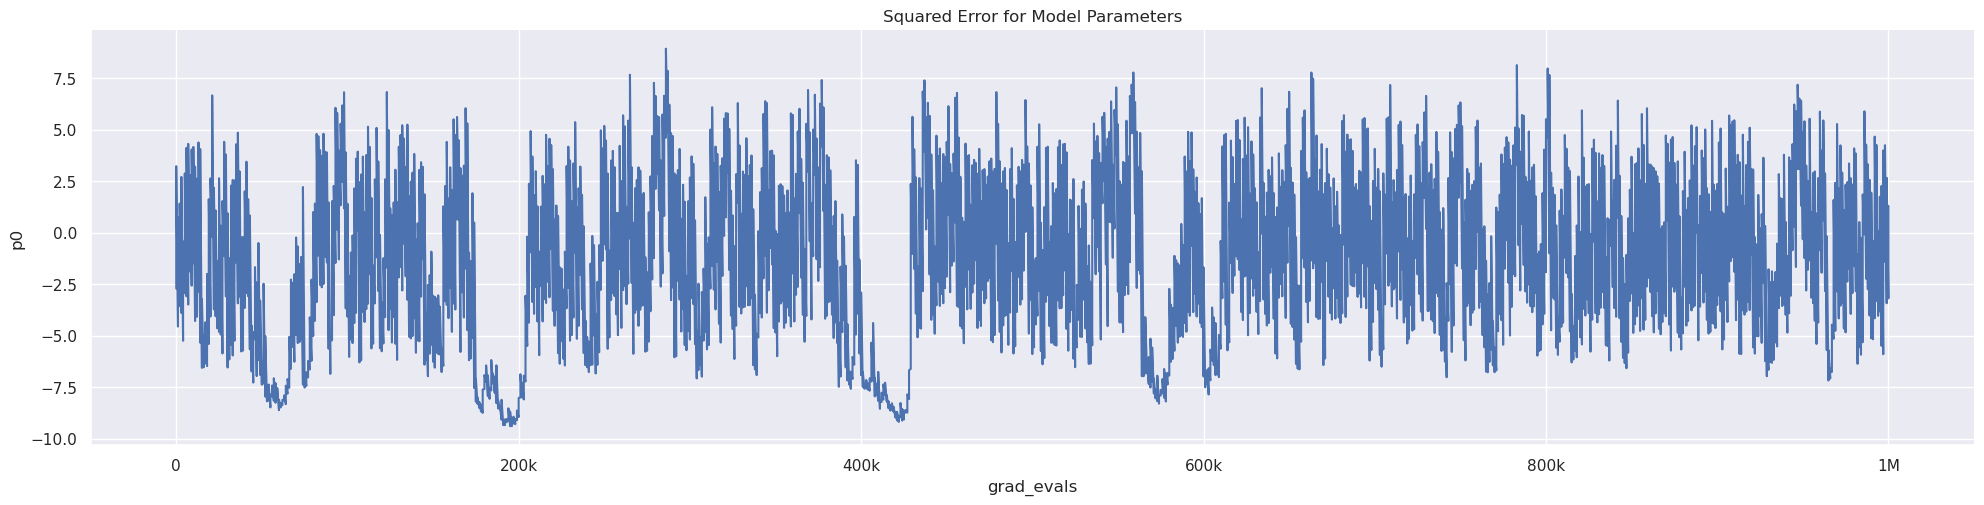

In [20]:
fig = sns.relplot(
    data=df,
    kind="line",
    x="grad_evals",
    y="p0",
    aspect=4,
    estimator=None,
    # errorbar=lambda x: (x.min(), x.max()),
)

# make y axis log scale
# fig.set(yscale="log")
fig.set(xticks=[0, 200_000, 400_000, 600_000, 800_000, 1_000_000], xticklabels=["0", "200k", "400k", "600k", "800k", "1M"])
fig.set(title="Squared Error for Model Parameters")

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


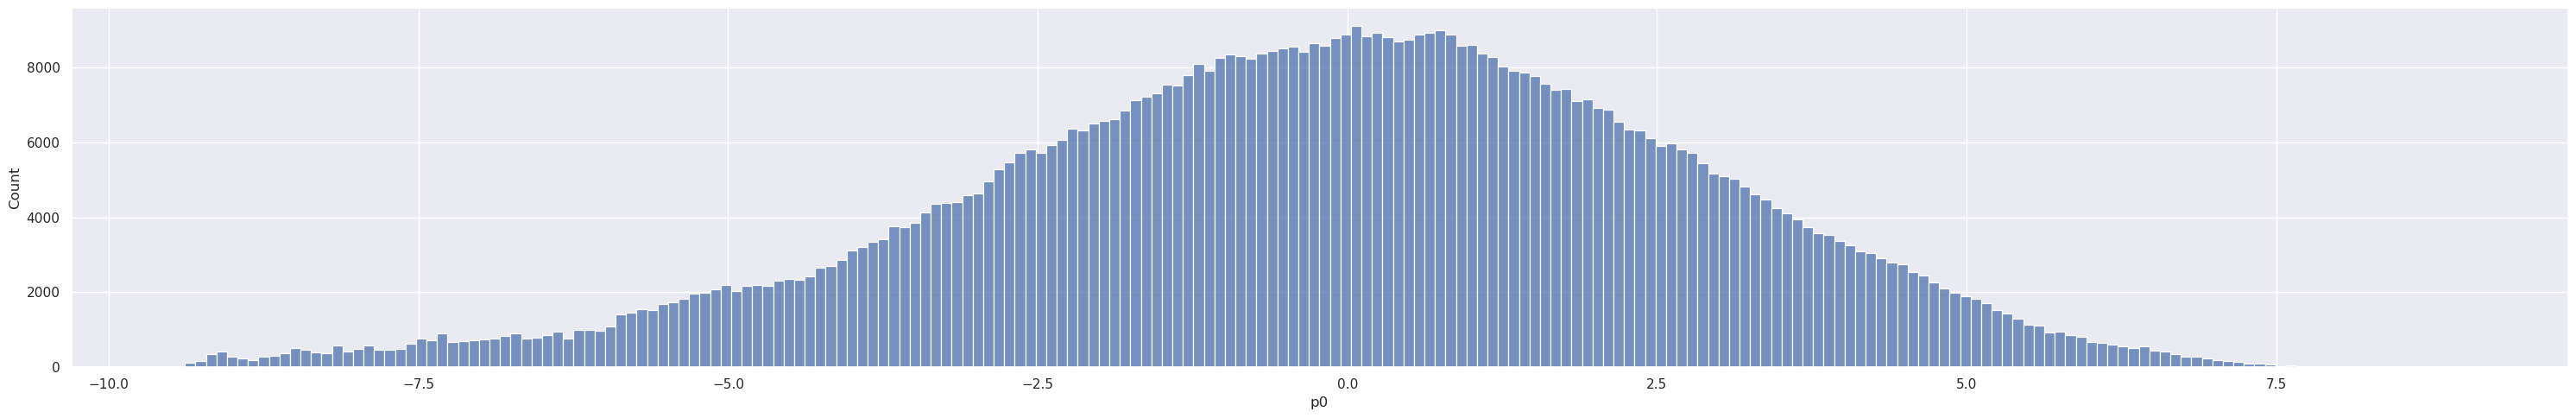

In [21]:
sns.displot(
    data=df,
    x="p0",
    kind="hist",
    aspect=6,
)

In [38]:
def get_df(param_str="sampler_type=nuts__seed=1234__burn_in=0__gradient_budget=1000000"):
    to_vstack = []
    for idx in range(5):
        to_hstack = []
        fname = param_str[:74] + f"{idx}" + param_str[75:]
        print(fname)
        
        history_path = os.path.join(data_dir, fname, "history.npz")
        history_np = np.load(history_path)
        metrics_path = os.path.join(data_dir, fname, "metrics.npz")
        metrics_np = np.load(metrics_path)
        
        to_hstack.append(history_np["grad_evals"].round(-3)) # .round(-4)
        to_hstack.append(history_np["draws"][:, 0])
        to_hstack.append(metrics_np["max_se1"])
        to_hstack.append(metrics_np["max_se2"])
        to_hstack.append(np.array([idx] * len(history_np["grad_evals"])))
        to_hstack.append(np.array(["drghmc"] * len(history_np["grad_evals"])))
        data = np.hstack([arr.reshape(-1, 1) for arr in to_hstack])
        to_vstack.append(data)
    
    data = np.vstack(to_vstack)
    schema = [("grad_evals", pl.UInt32), ("p0", pl.Float32), ("se1", pl.Float32),  ("se2", pl.Float32), ("chain", pl.UInt32), ("sampler", pl.Utf8)]
    return pl.from_numpy(data=data, schema=schema)
    
drghmc = get_df(param_str="sampler_type=drghmc__seed=1234__burn_in=0__gradient_budget=1000000__chain=0__step_count_method=const_step_count__step_size=None__step_size_factor=2.0__max_proposals=3__reduction_factor=4.0__damping=0.05__metric=1__probabilistic=False")
drghmc.tail()

sampler_type=drghmc__seed=1234__burn_in=0__gradient_budget=1000000__chain=0__step_count_method=const_step_count__step_size=None__step_size_factor=2.0__max_proposals=3__reduction_factor=4.0__damping=0.05__metric=1__probabilistic=False
sampler_type=drghmc__seed=1234__burn_in=0__gradient_budget=1000000__chain=1__step_count_method=const_step_count__step_size=None__step_size_factor=2.0__max_proposals=3__reduction_factor=4.0__damping=0.05__metric=1__probabilistic=False
sampler_type=drghmc__seed=1234__burn_in=0__gradient_budget=1000000__chain=2__step_count_method=const_step_count__step_size=None__step_size_factor=2.0__max_proposals=3__reduction_factor=4.0__damping=0.05__metric=1__probabilistic=False
sampler_type=drghmc__seed=1234__burn_in=0__gradient_budget=1000000__chain=3__step_count_method=const_step_count__step_size=None__step_size_factor=2.0__max_proposals=3__reduction_factor=4.0__damping=0.05__metric=1__probabilistic=False
sampler_type=drghmc__seed=1234__burn_in=0__gradient_budget=10000

grad_evals,p0,se1,se2,chain,sampler
u32,f32,f32,f32,u32,str
1000000,-6.237784,0.053164,132.591171,4,"""drghmc"""
1000000,-6.226754,0.053167,132.59082,4,"""drghmc"""
1000000,-6.211048,0.05317,132.590469,4,"""drghmc"""
1000000,-6.192302,0.053174,132.590103,4,"""drghmc"""
1000000,-6.174589,0.053177,132.589752,4,"""drghmc"""
